# Testing full pipeline

In [1]:
%load_ext autoreload
%autoreload 2
from network_metrics import *
from network_viz import draw_network

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
nruns = 200
names_df = pd.read_csv('data/alpha2/name_list.csv')
mentees_df = pd.read_csv('data/alpha2/mentees.csv')
mentors_df = pd.read_csv('data/alpha2/mentors.csv')

metrics = [
    {'function': run_frac_mentees_with_a_mentor,          'weight': 2, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentees_less_than_requested,    'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_assigned_mentees,       'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_with_extra_slots,       'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_overassigned,           'weight': 1, 'type':'binary0',  'normalize':False},
    {'function': run_frac_mentees_atleast_one_preference, 'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_any_avoid,                      'weight': 1, 'type':'binary0',  'normalize':False},
    #{'function': run_mean_clique_size,                    'weight': 2, 'type':'maximize', 'normalize':True},
    #{'function': run_n_cliques_gt2,                       'weight': 1, 'type':'maximize', 'normalize':True},
    {'function': run_frac_mentees_alternatives,           'weight': 1, 'type':'minimize', 'normalize':False},
    {'function': run_network_modularity,                  'weight': 3, 'type':'maximize', 'normalize':True}
]

output = create_best_network(nruns, names_df, mentees_df, mentors_df, metrics, nbest = 10, combine_metric_method='multiply')
print("best:", output['best']['combined_metric'])
for i in range(len(output['bestlist'])-1):
    print("next bests", i+1, ":", output['bestlist'][i+1]['combined_metric'])

best: 0.024920929096231424
next bests 1 : 0.02467925397306057
next bests 2 : 0.022304607147514064
next bests 3 : 0.021243984916872228
next bests 4 : 0.021085297364780573
next bests 5 : 0.020809677938559437
next bests 6 : 0.020736863915567397
next bests 7 : 0.02031946109545705
next bests 8 : 0.020211723818606208
next bests 9 : 0.020032315935626554


best network values:
frac_mentees_with_a_mentor : 0.9487179487179487
frac_mentees_less_than_requested : 0.1794871794871795
frac_mentors_assigned_mentees : 0.9722222222222222
frac_mentors_with_extra_slots : 0.2777777777777778
frac_mentors_overassigned : 0.0
frac_mentees_atleast_one_preference : 0.782608695652174
frac_any_avoid : 0.0
frac_mentees_alternatives : 0.2564102564102564
network_modularity : 0.509204152249135


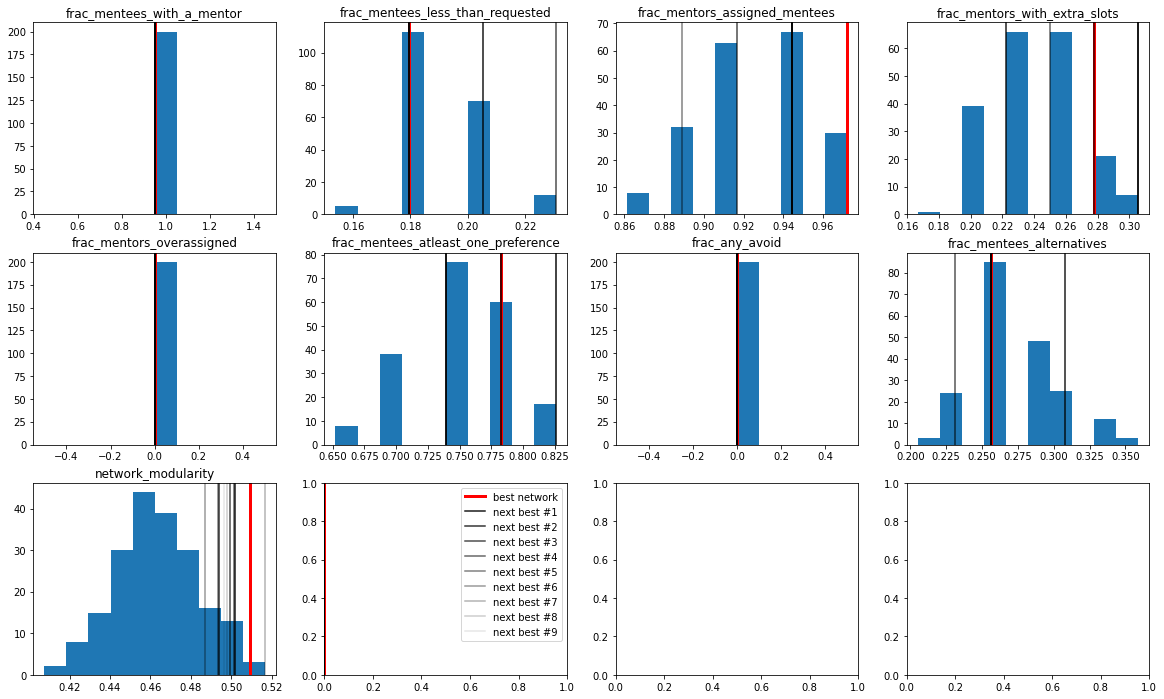

In [4]:
# plot all the metrics
nc = 4
nr = int(np.ceil(len(metrics)/nc))
fig,axs = plt.subplots(nr, nc, figsize = (20,12))
for i,ax in enumerate(axs.flatten()):
    if (i < len(metrics)):
        ax.hist(output['raw_metrics'][i], align = 'mid')
        ax.set_title(output['metric_names'][i])
        ax.axvline(output['raw_metrics'][i][output['best']['index']], color = 'red', lw = 3, label = 'best network')
        for ib in range(len(output['bestlist'])-1):
            ax.axvline(output['raw_metrics'][i][output['bestlist'][ib+1]['index']], color = 'black', lw = 1.5, alpha = (1.0-(ib+1)/10), label = 'next best #%d' %(ib+1))
    if i == len(metrics):
        ax.axvline(0, color = 'red', lw = 3, label = 'best network')
        for ib in range(len(output['bestlist'])-1):
            ax.axvline(0, color = 'black', lw = 1.5, alpha = (1.0-(ib+1)/10), label = 'next best #%d' %(ib+1))
        ax.legend()
        
print ("best network values:")
for i in range(len(metrics)):
    print(output['metric_names'][i], ':', output['raw_metrics'][i][output['best']['index']])

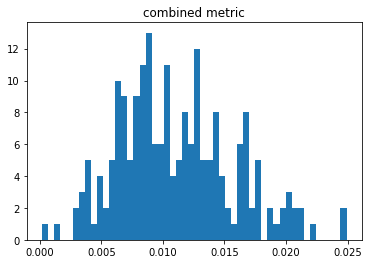

In [5]:
# plot the combined metric
f,ax = plt.subplots()
_ = ax.hist(output['combined_metric'], bins=50)
_ = ax.set_title('combined metric')

In [ ]:
_ = draw_network(output['best']['network'])

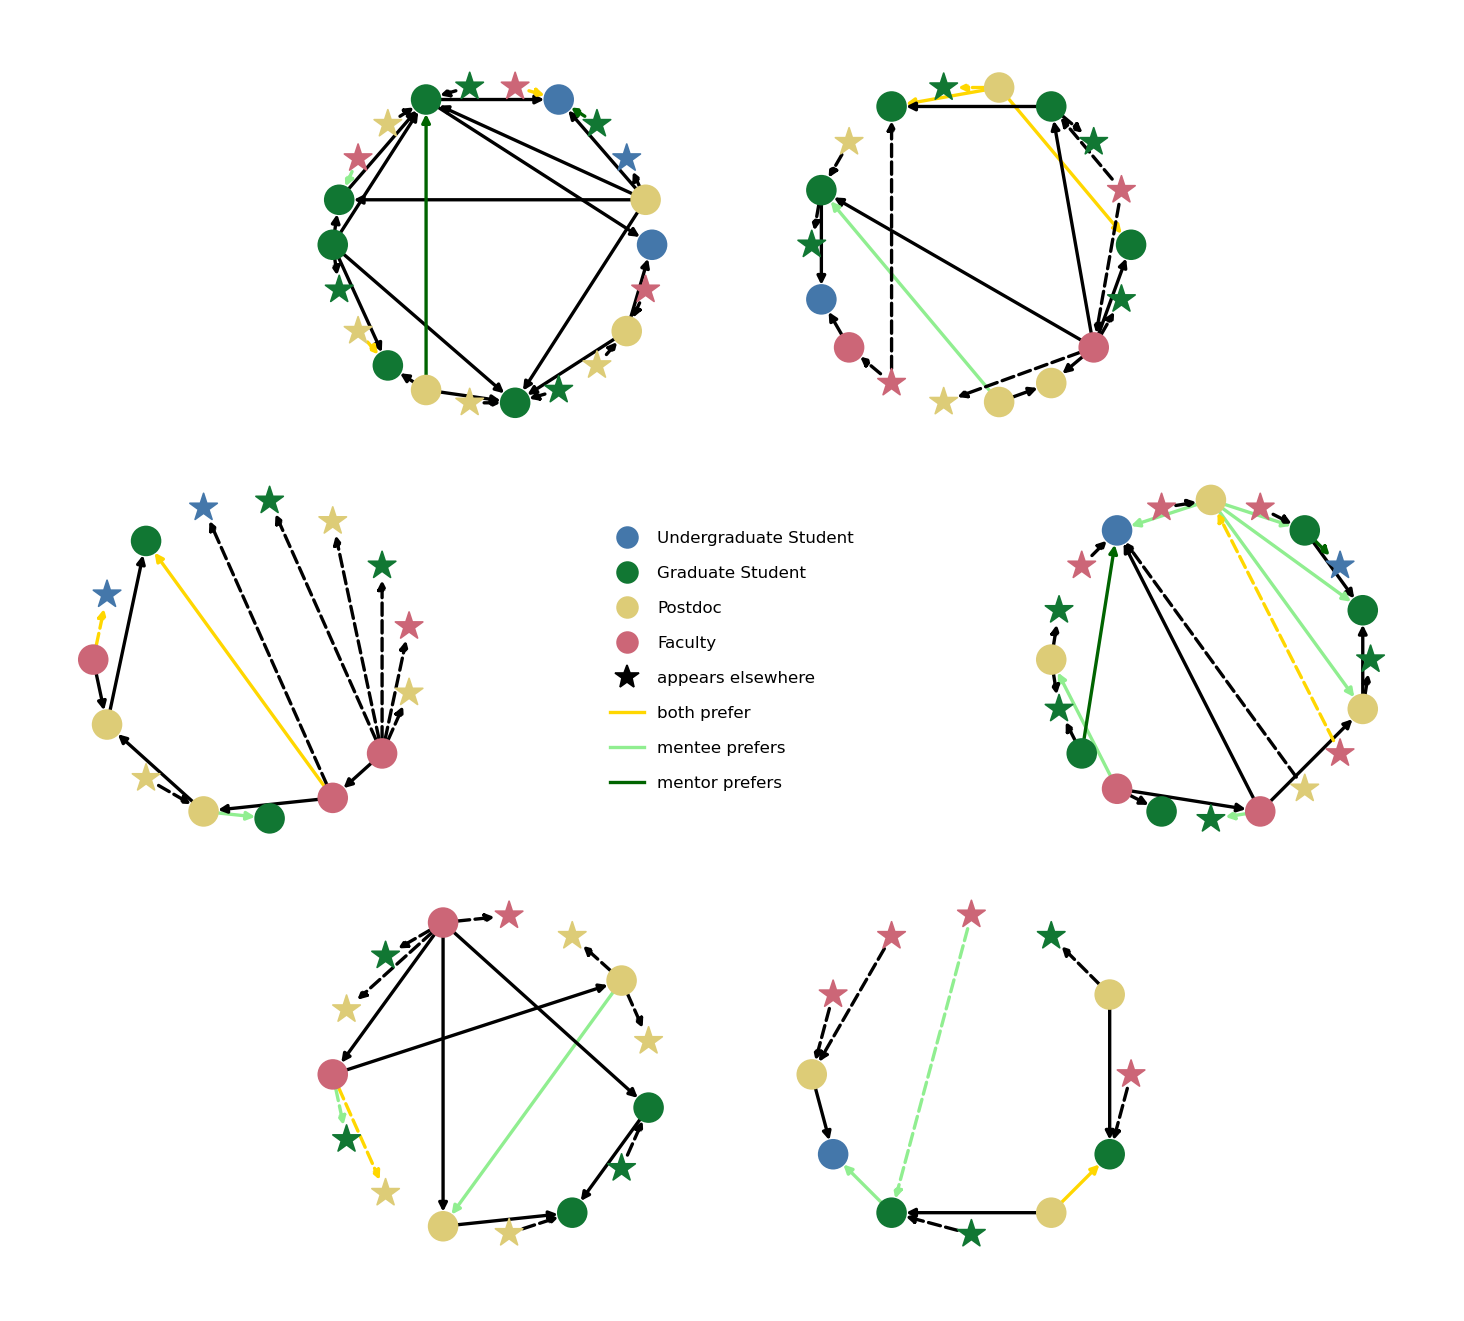

In [11]:
_ = draw_network(output['bestlist'][9]['network'])

In [6]:
from network_viz import list_matches

In [7]:
matches = list_matches(output['best']['network'])

/Users/tjitske/Documents/OverigeWerk/CIRTL-and-Mentoring/CIERAextendedMentoringStrucutre2022/JEDI_ext_mentorship/network_analysis.py:140: RuntimeWarning: divide by zero encountered in double_scalars
  m2 = (p2b.y-p2a.y)/(p2b.x-p2a.x)
/Users/tjitske/Documents/OverigeWerk/CIRTL-and-Mentoring/CIERAextendedMentoringStrucutre2022/JEDI_ext_mentorship/network_analysis.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  m1 = (p1b.y-p1a.y)/(p1b.x-p1a.x)
/Users/tjitske/Documents/OverigeWerk/CIRTL-and-Mentoring/CIERAextendedMentoringStrucutre2022/JEDI_ext_mentorship/network_analysis.py:180: RuntimeWarning: invalid value encountered in matmul
  xcross,ycross = np.matmul(np.linalg.pinv(mat),vec)[:,0]


In [8]:
matches

['mentor Postdoc: YusufLucas is matched to mentee Undergraduate Student: HarrisBryan',
 'mentor Postdoc: YusufLucas is matched to mentee Postdoc: StanleyNaylor',
 'mentor Postdoc: AlexanderMitchell is matched to mentee Graduate Student: QuinnCobb',
 'mentor Faculty: LillyNorton is matched to mentee Postdoc: ChristianaBuckner',
 'mentor Faculty: LillyNorton is matched to mentee Faculty: SaniaNorman',
 'mentor Faculty: LillyNorton is matched to mentee Graduate Student: HannahRivas',
 'mentor Graduate Student: HannahRivas is matched to mentee Undergraduate Student: HarrisBryan',
 'mentor Graduate Student: HannahRivas is matched to mentee Graduate Student: BrennanStanton',
 'mentor Faculty: SaniaNorman is matched to mentee Postdoc: YusufLucas',
 'mentor Faculty: SaniaNorman is matched to mentee Graduate Student: BrennanStanton',
 'mentor Postdoc: ChristianaBuckner is matched to mentee Graduate Student: QuinnCobb',
 'mentor Postdoc: JoseffMercer is matched to mentee Graduate Student: Brenna

In [10]:
from network_viz import get_positions

In [230]:
this_network = output['best']['network']
pods,pos_dicts,missing_edgess,anti_nodess = get_positions(this_network)

In [ ]:
draw_network(
    this_network,
    pods,
    pos_dicts,
    missing_edgess,
    anti_nodess,
    scale_fact=1,
    show_remaining_spots=True,
    single_axis=True)
print()

In [59]:
nodes[4].mentees_remaining

0

# Scratch space below ...

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
import networkx as nx

In [12]:
import pandas as pd

In [13]:
from mentor_matching import reduce_full_tables

In [14]:
names_df = pd.read_csv('data/alpha2/name_list.csv')
all_names = names_df.loc[:,::2].values.flatten()
for i in range(len(all_names)): 
    name = all_names[i]
    if type(name) == str:
        all_names[i] = name.replace(' ','')

## show just the first 5 rows
names_df.head()

,Faculty,Unnamed: 1,Postdoc,Unnamed: 3,Graduate Student,Unnamed: 5,Undergraduate Student,Unnamed: 7
0,Lilly Norton,NK,Christiana Buckner,NK,Subhaan Walsh,NK,Maira Nava,NK
1,Anand Coulson,AMG,Yusuf Lucas,NK,Amaan Terry,NK,Marius Beil,TS
2,Ruby-Leigh Holloway,AMG,Indigo Cope,TS,Brennan Stanton,TS,Khia Galindo,AMG
3,Kacie Chandler,NaN,Felicity Vo,TS,Quinn Cobb,AMG,Willem Swan,AMG
4,Iosif Chaney,NaN,Alexander Mitchell,AMG,Hannah Rivas,AMG,Harris Bryan,NaN


In [15]:
mentees_df = pd.read_csv('data/alpha2/mentees.csv')
#mentees_df.head()

In [16]:
mentors_df = pd.read_csv('data/alpha2/mentors.csv')
#mentors_df.head()

In [17]:
people = reduce_full_tables(names_df,mentees_df,mentors_df)

ValueError: 'Undergraduate student' is not in list

In [35]:
for person in people.values():
    if person.rank == 0:
        person.print_preferences()

Undergraduate Student: MairaNava
nmentors: 2 [1. 1. 0. 0.]
nmentees: 0 [0. 0. 0. 0.] (0)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: ['SubhaanWalsh']
------

Undergraduate Student: MariusBeil
nmentors: 5 [2. 1. 1. 1.]
nmentees: 1 [1. 0. 0. 0.] (1)
------
avoid  mentees: []
avoid  mentors: ['FelicityVo']
------
prefer mentees: []
prefer mentors: ['SaniaNorman', 'IndigoCope']
------

Undergraduate Student: KhiaGalindo
nmentors: 4 [1. 1. 1. 1.]
nmentees: 0 [0. 0. 0. 0.] (0)
------
avoid  mentees: []
avoid  mentors: ['AlexanderMitchell']
------
prefer mentees: []
prefer mentors: ['AnandCoulson']
------

Undergraduate Student: WillemSwan
nmentors: 2 [1. 0. 0. 1.]
nmentees: 0 [0. 0. 0. 0.] (0)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: []
------

Undergraduate Student: HarrisBryan
nmentors: 0 [0. 0. 0. 0.]
nmentees: 0 [0. 0. 0. 0.] (0)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []


--------

In [9]:
from mentor_matching import generate_network
from network_metrics import *

In [10]:
nruns = 200
network_list = []
people_list = []
vals = np.zeros((10,nruns))
for i in range(nruns):
    #print ('round', i)
    people, network = generate_network(names_df,mentees_df,mentors_df,loud=False)
    network_list.append(network)
    people_list.append(people)
    vals[:,i],names = run_all_metrics(people, network) #leaving this in for now, but not strictly necessary if weighting is desired

matched mentee: GradStudents: MujtabaDejesus with mentor: GradStudents: NylaRodriguez
GradStudents: MujtabaDejesus
nmentors: 1 [0. 1. 0. 0.]
matched : 1 [0. 1. 0. 0.]
------
nmentees: 0 [0. 0. 0. 0.] (0)
matched : 0 [0. 0. 0. 0.]

GradStudents: NylaRodriguez
nmentors: 0 [0. 0. 0. 0.]
matched : 0 [0. 0. 0. 0.]
------
nmentees: 2 [1. 1. 0. 0.] (2)
matched : 1 [0. 1. 0. 0.]

matched mentee: Postdocs: ChristianaBuckner with mentor: Faculty: LillyNorton
Postdocs: ChristianaBuckner
nmentors: 3 [0. 0. 2. 1.]
matched : 1 [0. 0. 0. 1.]
------
nmentees: 0 [0. 0. 0. 0.] (0)
matched : 0 [0. 0. 0. 0.]

Faculty: LillyNorton
nmentors: 0 [0. 0. 0. 0.]
matched : 0 [0. 0. 0. 0.]
------
nmentees: 3 [1. 1. 1. 0.] (2)
matched : 1 [0. 0. 1. 0.]

matched mentee: GradStudents: MujtabaDejesus with mentor: GradStudents: NylaRodriguez
GradStudents: MujtabaDejesus
nmentors: 1 [0. 1. 0. 0.]
matched : 1 [0. 1. 0. 0.]
------
nmentees: 0 [0. 0. 0. 0.] (0)
matched : 0 [0. 0. 0. 0.]

GradStudents: NylaRodriguez
nmentor

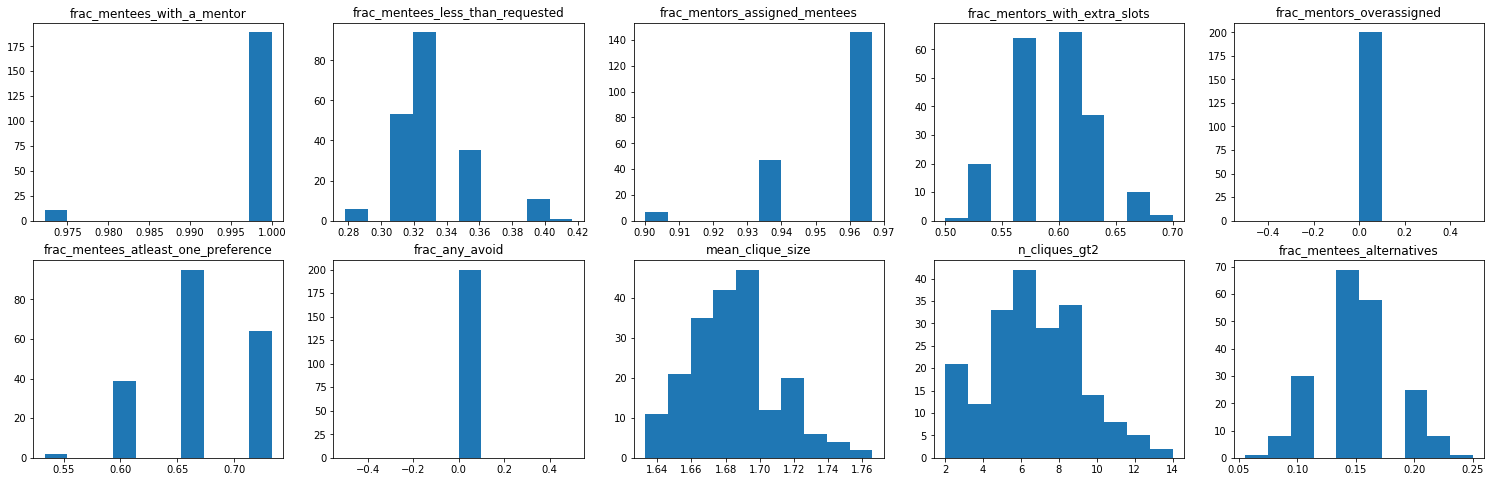

In [11]:
fig,axs = plt.subplots(nrows=2,ncols=5)
for i,ax in enumerate(axs.flatten()):
    if (i < len(vals)):
        ax.hist(vals[i], align = 'mid')
        ax.set_title(names[i])
fig.set_size_inches(26,8)

In [84]:
vals.shape

(10, 200)

In [58]:
# testing a method to pick the best network
# in order of vals array
# 0: (top) maximize frac_mentees_with_a_mentor
# 1: maximize frac_mentees_less_than_requested
# 2: maximize frac_mentors_assigned_mentees ?
# 3: maximize frac_mentors_with_extra_slots ?
# 4: (top) throw out any with frac_mentors_overassigned --> required check
# 5: maximize frac_mentees_atleast_one_preference
# 6: (top) throw out any with frac_any_avoid > 0 --> required check
# 7: (top) maximize mean_clique_size
# 8: maximize n_cliques_gt
# 9: minmize alternative mentor assignments

combined_metric = [0]*nruns
topfac = 2.
midfac = 1.
#for normalizing the clique size
def norm_n_metric(val, arr):
    return (val - min(arr))/(max(arr) - min(arr))

for i in range(nruns):
    #top priority
    top = vals[0, i]*norm_n_metric(vals[7, i], vals[7])
    if (vals[4, i] > 0 or vals[6, i] > 0):
        top = 0
        
    #less important
    mid = vals[1,i]*vals[2,i]*vals[3,i]*vals[5,i]*norm_n_metric(vals[8,i], vals[8])
    
    #sum (note: this is some combined multiply and weighted average method...)
    combined_metric[i] = (topfac*top + midfac*mid)/(topfac + midfac)

#just a check
best = [i for (i, x) in enumerate(combined_metric) if x > 0.5]
print(best)
print(combined_metric[best[0]])
print('N with combined_metric > 0.7', len(best))
the_best = networks[best[0]]

[164]
0.7122962962962963
N with combined_metric > 0.7 1


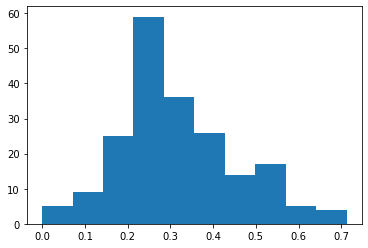

In [88]:
f, ax = plt.subplots()
_ = ax.hist(combined_metric)

In [85]:
# testing a method to pick the best network
# in order of vals array
# 0: (top) maximize frac_mentees_with_a_mentor
# 1: maximize frac_mentees_less_than_requested
# 2: maximize frac_mentors_assigned_mentees ?
# 3: maximize frac_mentors_with_extra_slots ?
# 4: (top) throw out any with frac_mentors_overassigned --> required check
# 5: maximize frac_mentees_atleast_one_preference
# 6: (top) throw out any with frac_any_avoid > 0 --> required check
# 7: (top) maximize mean_clique_size
# 8: maximize n_cliques_gt
# 9: minmize alternative mentor assignments

from network_metrics import *

metrics = [
    {'function': run_frac_mentees_with_a_mentor,          'weight': 2, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentees_less_than_requested,    'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_assigned_mentees,       'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_with_extra_slots,       'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_overassigned,           'weight': 1, 'type':'binary0',  'normalize':False},
    {'function': run_frac_mentees_atleast_one_preference, 'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_any_avoid,                      'weight': 1, 'type':'binary0',  'normalize':False},
    {'function': run_mean_clique_size,                    'weight': 2, 'type':'maximize', 'normalize':True},
    {'function': run_n_cliques_gt2,                       'weight': 1, 'type':'maximize', 'normalize':True},
    {'function': run_frac_mentees_alternatives,           'weight': 1, 'type':'minimize', 'normalize':False},
]

multiply_metrics = run_weighted_metrics(people_list, network_list, metrics, method='multiply')
add_metrics = run_weighted_metrics(people_list, network_list, metrics, method='mean')

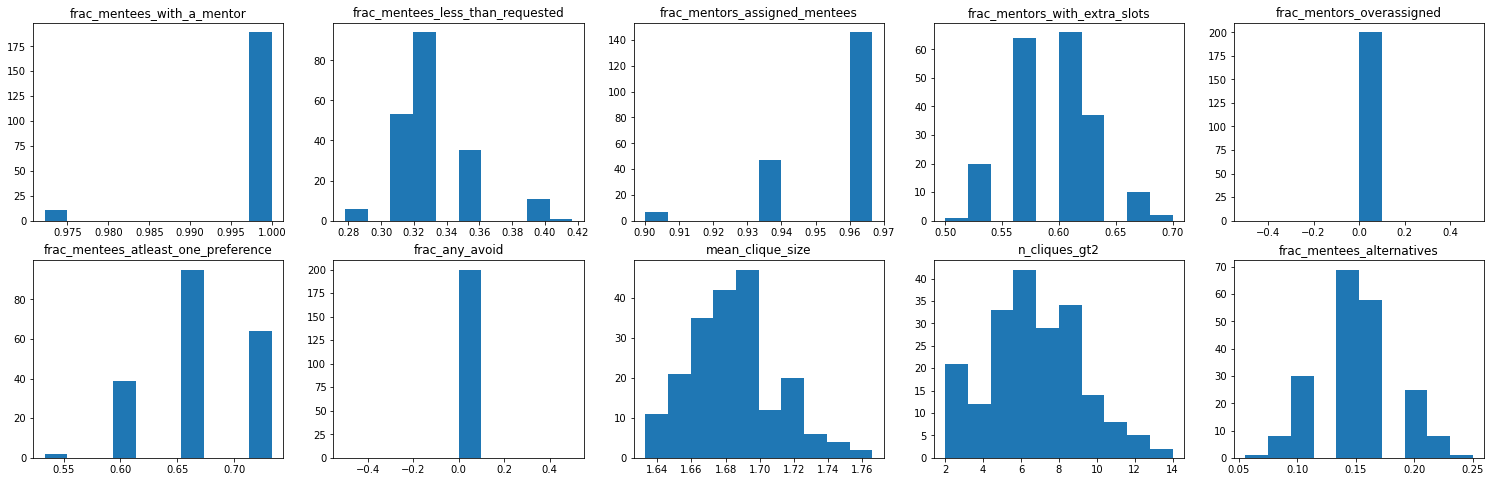

In [86]:
nc = 5
nr = int(np.ceil(len(metrics)/nc))
fig,axs = plt.subplots(nrows = nr, ncols = nc)
for i,ax in enumerate(axs.flatten()):
    if (i < len(metrics)):
        ax.hist(multiply_metrics['raw_metrics'][i], align = 'mid')
        ax.set_title(multiply_metrics['metric_names'][i])
fig.set_size_inches(26,8)

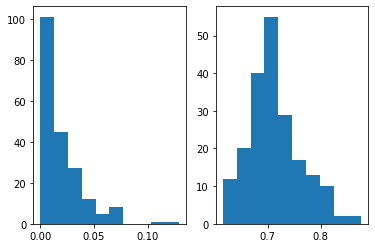

In [87]:
f, ax = plt.subplots(1, 2)
_ = ax[0].hist(multiply_metrics['combined_metric'])
_ = ax[1].hist(add_metrics['combined_metric'])

MultiDiGraph with 9 nodes and 8 edges but missing 4 edges
MultiDiGraph with 9 nodes and 11 edges but missing 12 edges
MultiDiGraph with 8 nodes and 7 edges but missing 5 edges
MultiDiGraph with 7 nodes and 7 edges but missing 8 edges
MultiDiGraph with 7 nodes and 8 edges but missing 11 edges
MultiDiGraph with 5 nodes and 6 edges but missing 4 edges
MultiDiGraph with 4 nodes and 3 edges but missing 6 edges


/Users/agurvich/Desktop/ExtraCurricular/CIERA/mentoring/network_analysis.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  if p1a.x > p1b.x: p1a,p1b = p1b,p1a
/Users/agurvich/Desktop/ExtraCurricular/CIERA/mentoring/network_analysis.py:179: RuntimeWarning: invalid value encountered in matmul
  elif vert_2 and p2a.contained_in_domain(p1a,p1b):
/Users/agurvich/Desktop/ExtraCurricular/CIERA/mentoring/network_analysis.py:138: RuntimeWarning: divide by zero encountered in double_scalars
  p1b = Point(*pos_dict[node1b])


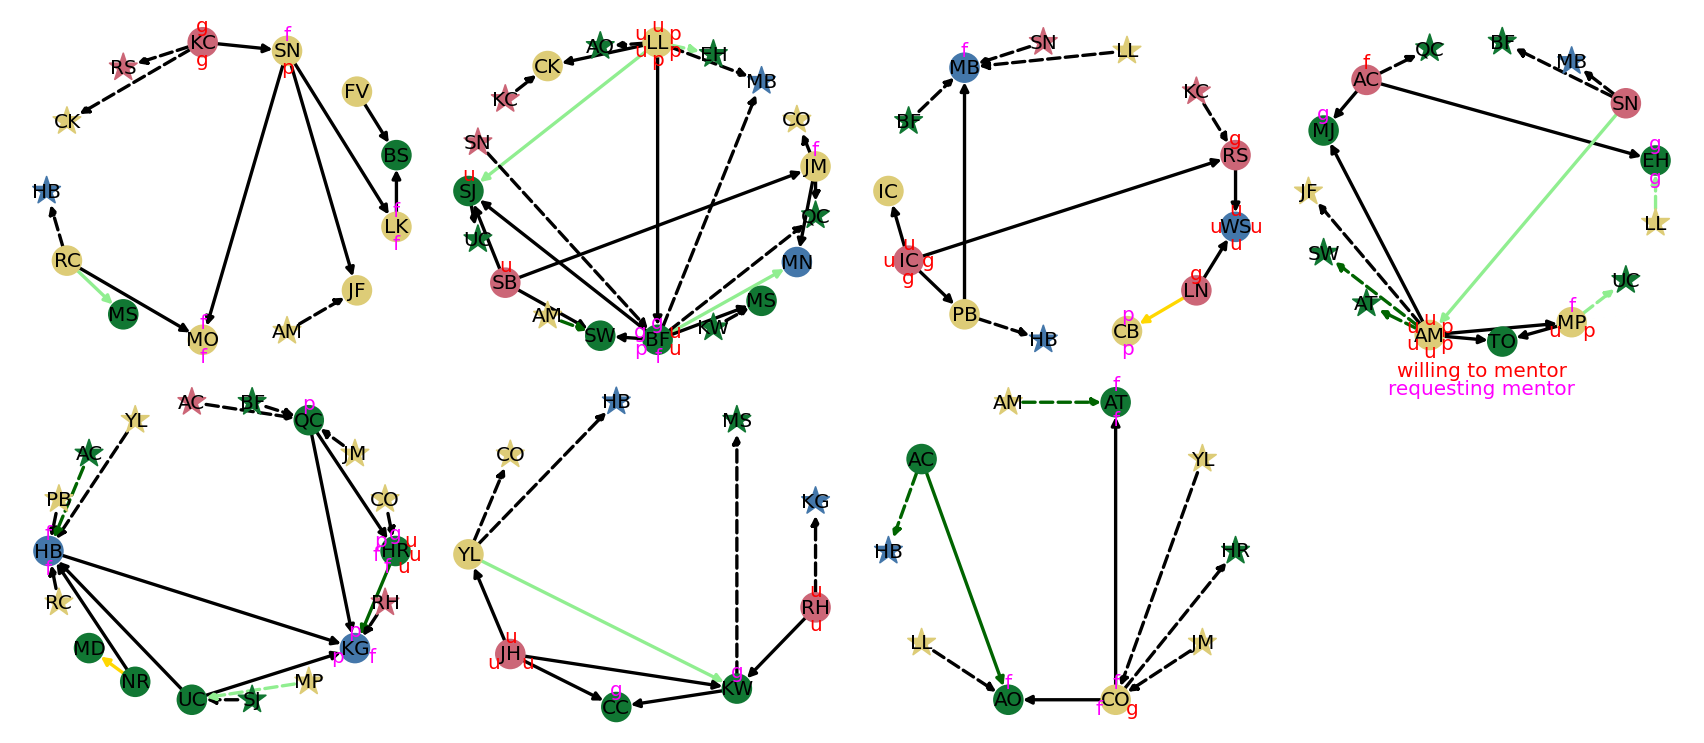

In [19]:
from network_viz import draw_network
pod,pos_dict = draw_network(the_best,scale_fact=1,simple_pos=False,add_missing_edges=True)
print()

In [204]:
from network_analysis import detangle_edges

In [208]:
detangle_edges(pod,pos_dict)

{GradStudents: AryaanCooke: array([ 1.19248806e-08, -1.00000000e+00]),
 GradStudents: AmaanTerry: array([-1.00000000e+00, -8.74227766e-08]),
 GradStudents: AllanOchoa: array([1.00000000e+00, 1.74845553e-07]),
 Postdocs: CohenO'Moore: array([-3.37766238e-07,  1.00000000e+00])}

/Users/agurvich/Desktop/ExtraCurricular/CIERA/mentoring/network_analysis.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  m1 = (p1b.y-p1a.y)/(p1b.x-p1a.x)


True

In [131]:
edges = list(pod.edges())
edge1 = edges[0]
edge2 = edges[2]
print(determine_if_cross(edge1,edge2,pos_dict))
edges

True


/Users/agurvich/Desktop/ExtraCurricular/CIERA/mentoring/network_analysis.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  m1 = (p1b.y-p1a.y)/(p1b.x-p1a.x)
/Users/agurvich/Desktop/ExtraCurricular/CIERA/mentoring/network_analysis.py:112: RuntimeWarning: divide by zero encountered in double_scalars
  m2 = (p2b.y-p2a.y)/(p2b.x-p2a.x)


[(Postdocs: StanleyNaylor, Postdocs: LesterKenny),
 (Postdocs: StanleyNaylor, Postdocs: JarradFriedman),
 (Postdocs: StanleyNaylor, Postdocs: MirunaO'Ryan),
 (Postdocs: FelicityVo, GradStudents: BrennanStanton),
 (Faculty: KacieChandler, Postdocs: StanleyNaylor),
 (Postdocs: Ruby-MayConway, GradStudents: MaiSalter),
 (Postdocs: Ruby-MayConway, Postdocs: MirunaO'Ryan),
 (Postdocs: LesterKenny, GradStudents: BrennanStanton)]

In [103]:
find_planar_crossing_edges(pod,pos_dict)

[(Faculty: AnandCoulson, GradStudents: MaxineJacobson, 0),
 (Faculty: SaniaNorman, Postdocs: AlexanderMitchell, 0),
 (Faculty: AnandCoulson, GradStudents: EverettHowells, 0),
 (Postdocs: AlexanderMitchell, GradStudents: MaxineJacobson, 0),
 (Faculty: AnandCoulson, GradStudents: EverettHowells, 0),
 (Faculty: SaniaNorman, Postdocs: AlexanderMitchell, 0),
 (Faculty: AnandCoulson, GradStudents: EverettHowells, 0),
 (Postdocs: MehreenPearson, GradStudents: TariqO'Sullivan, 0),
 (Postdocs: AlexanderMitchell, GradStudents: MaxineJacobson, 0),
 (Postdocs: MehreenPearson, GradStudents: TariqO'Sullivan, 0)]